This notebook summarizes the counts for target gene and DRSC regions.

In [1]:
# %load ../start.py
# Load useful extensions
import os
import sys

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 1

# Set up cashdir
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -v -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
sys.path.insert(0, '../../lcdb-wf/lib')
sys.path.insert(0, '../../lib/python')

# Set up references
import yaml
with open('../../config/config.yml') as fh:
    config = yaml.load(fh)

assembly = config['assembly']
tag = config['aligner']['tag']
REF = os.path.join(os.environ['REFERENCES_DIR'], assembly, tag)

%matplotlib inline

last updated: 2017-09-20 

CPython 3.5.2
IPython 6.1.0
Git hash: b31c213e0fbaedf9092be694730dd537cd996a08


In [2]:
# imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
stable = pd.read_csv('../../config/sampletable.tsv', sep='\t')

In [4]:
stable.head()

,samplename,SRX,BioSample,GEO,drsc,target_FBgn,target_symbol,drsc_rep,rep,plate_id,well_id,plate_row,plate_column
0,SRR3486891,SRX1748887,SAMN04959321,GSM2145154,DRSC07681,FBgn0003396,shn,2,1,1,E8,E,8
1,SRR3486986,SRX1748983,SAMN04959673,GSM2145249,DRSC07681,FBgn0003396,shn,2,2,1,E8,E,8
2,SRR3487576,SRX1749576,SAMN04960293,GSM2145839,DRSC15627,FBgn0038742,Arc42,2,2,4,G4,G,4
3,SRR3487481,SRX1749480,SAMN04960137,GSM2145744,DRSC15627,FBgn0038742,Arc42,2,1,4,G4,G,4
4,SRR3486819,SRX1748815,SAMN04959150,GSM2145082,DRSC32770,FBgn0011715,Snr1,2,2,10,G7,G,7


In [5]:
srrs = stable.samplename.unique().tolist()
lacz = stable[stable.target_symbol == 'LacZ'].samplename.unique().tolist()
drsc = stable[stable.target_symbol != 'LacZ'].samplename.unique().tolist()

In [6]:
len(srrs), len(lacz), len(drsc)

(1900, 20, 1880)

In [7]:
dfs = []
pattern = '../../rnaseq-wf/data/rnaseq_samples/{srr}/{srr}.cutadapt.bam.drsc.counts'
for srr in drsc:
    fname = pattern.format(srr=srr)
    if os.path.exists(fname):
        dfs.append(pd.read_table(fname))

df = pd.concat(dfs, ignore_index=True)

In [8]:
print(df.shape)
df.head()

(1880, 9)


,srr,drsc,drsc_count,drsc_length,gene,gene_count,gene_length,sub_count,sub_length
0,SRR3486891,DRSC07681,336,513,FBgn0003396,911,10997,593,10484
1,SRR3486986,DRSC07681,221,513,FBgn0003396,391,10997,170,10484
2,SRR3487576,DRSC15627,163,141,FBgn0038742,181,1418,20,1277
3,SRR3487481,DRSC15627,35,141,FBgn0038742,57,1418,24,1277
4,SRR3486819,DRSC32770,21,158,FBgn0011715,125,1335,110,1177


In [9]:
# plotting function
import seaborn as sns
def make_plot(x, y, xlabel, ylabel, ax):
    sns.regplot(x, y, ax=ax, 
                scatter_kws={
                    'color': 'black',
                    's': 3,
                }, 
                ci=False, 
                line_kws={
                    'color': 'red',
                    'ls': '--',
                    'lw': 1,
                },
               )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

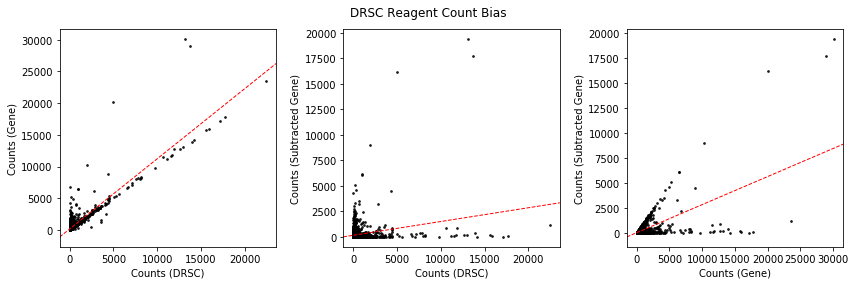

In [10]:
# Raw counts
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3))
make_plot(df['drsc_count'], df['gene_count'], 'Counts (DRSC)', 'Counts (Gene)', ax1)
make_plot(df['drsc_count'], df['sub_count'], 'Counts (DRSC)', 'Counts (Subtracted Gene)', ax2)
make_plot(df['gene_count'], df['sub_count'], 'Counts (Gene)', 'Counts (Subtracted Gene)', ax3)
plt.suptitle('DRSC Reagent Count Bias')
plt.tight_layout(rect=[0, 0, 1, .95])

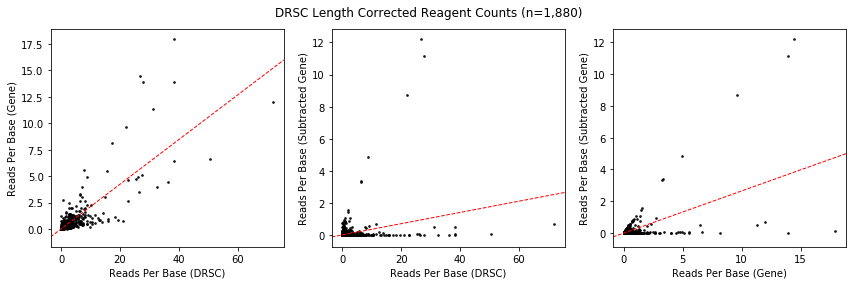

In [11]:
# Length normalized counts
drsc_rpb = df.drsc_count / df.drsc_length
sub_rpb = df.sub_count / df.sub_length
gene_rpb = df.gene_count / df.gene_length

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3))
    
make_plot(drsc_rpb, gene_rpb, 'Reads Per Base (DRSC)', 'Reads Per Base (Gene)', ax1)
make_plot(drsc_rpb, sub_rpb, 'Reads Per Base (DRSC)', 'Reads Per Base (Subtracted Gene)', ax2)
make_plot(gene_rpb, sub_rpb, 'Reads Per Base (Gene)', 'Reads Per Base (Subtracted Gene)', ax3)
plt.suptitle('DRSC Length Corrected Reagent Counts (n={:,})'.format(len(drsc)))
plt.tight_layout(rect=[0, 0, 1, .95])